In [1]:
import os
import random
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("ggplot")
%matplotlib inline



from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import (Input, BatchNormalization, Activation, Dense, Dropout, Flatten, 
                          Conv3D, Conv3DTranspose, MaxPooling3D)
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

ModuleNotFoundError: No module named 'keras.layers.core'

### preview of a sample

In [ ]:
mask_data = genfromtxt("data/mask/msk_300.csv", delimiter =',')

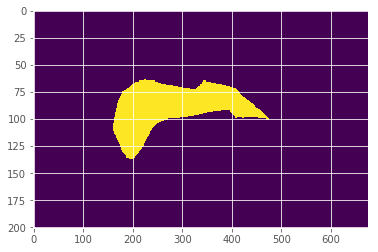

In [4]:
mask_data = mask_data.reshape(676,201)
plt.imshow(mask_data.T, cmap="viridis", vmin=0, vmax=1, aspect='auto')
plt.show()

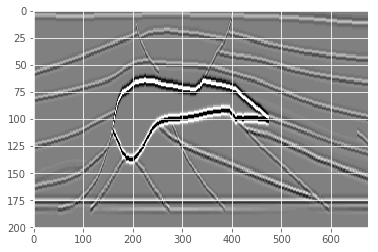

In [5]:
img_data = genfromtxt("data/image/img_300.csv", delimiter =',')
img_data = img_data.reshape(676,201)
vm = np.percentile(img_data, 99)
plt.imshow(img_data.T, cmap="gray", vmin=-vm, vmax=vm, aspect='auto')
plt.show()

In [3]:
# Set some parameters
im_depth = 32
im_width = 32
im_height = 32
border = 5

In [5]:
X = np.zeros((len(ids), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(ids), 128, 128, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [6]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = np.loadtxt(open("data/image/"+id_, "rb"), delimiter= ',')
    x_img = img.T
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [7]:
#ids = next(os.walk("data/mask"))[2] # list of names all images in the given path  
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load mask
    id_ = "msk_"+id_[-7:]
    mask = np.loadtxt(open("data/mask/"+id_, "rb"), delimiter= ',')
    mask = mask.T
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)    
    # Save mask
    
    y[n] = mask

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [32]:
X.shape

(676, 128, 128, 1)

In [33]:
y.shape

(676, 128, 128, 1)

In [31]:
128//32

4

In [4]:
676//32

21

In [8]:
X_3d = np.zeros((676//im_depth*(128//im_depth)*(128//im_height), im_depth, im_height, im_width, 1), dtype=np.float32)
y_3d = np.zeros((676//im_depth*(128//im_depth)*(128//im_height), im_depth, im_height, im_width, 1), dtype=np.float32)

In [9]:
X_3d.shape

(336, 32, 32, 32, 1)

In [21]:
for i in range(676//im_depth):
    for j in range(128//im_width):
        for k in range(128//im_height):
            indx =  i*((128//im_width)*(128//im_height))+j*(128//im_height)+k
            print(i,j,k,indx)
            X_3d[indx]=X[i*im_depth:(i+1)*im_depth, j*im_width:(j+1)*im_width, k*im_height:(k+1)*im_height]
            y_3d[indx]=y[i*im_depth:(i+1)*im_depth, j*im_width:(j+1)*im_width, k*im_height:(k+1)*im_height]

0 0 0 0
0 0 1 1
0 0 2 2
0 0 3 3
0 1 0 4
0 1 1 5
0 1 2 6
0 1 3 7
0 2 0 8
0 2 1 9
0 2 2 10
0 2 3 11
0 3 0 12
0 3 1 13
0 3 2 14
0 3 3 15
1 0 0 16
1 0 1 17
1 0 2 18
1 0 3 19
1 1 0 20
1 1 1 21
1 1 2 22
1 1 3 23
1 2 0 24
1 2 1 25
1 2 2 26
1 2 3 27
1 3 0 28
1 3 1 29
1 3 2 30
1 3 3 31
2 0 0 32
2 0 1 33
2 0 2 34
2 0 3 35
2 1 0 36
2 1 1 37
2 1 2 38
2 1 3 39
2 2 0 40
2 2 1 41
2 2 2 42
2 2 3 43
2 3 0 44
2 3 1 45
2 3 2 46
2 3 3 47
3 0 0 48
3 0 1 49
3 0 2 50
3 0 3 51
3 1 0 52
3 1 1 53
3 1 2 54
3 1 3 55
3 2 0 56
3 2 1 57
3 2 2 58
3 2 3 59
3 3 0 60
3 3 1 61
3 3 2 62
3 3 3 63
4 0 0 64
4 0 1 65
4 0 2 66
4 0 3 67
4 1 0 68
4 1 1 69
4 1 2 70
4 1 3 71
4 2 0 72
4 2 1 73
4 2 2 74
4 2 3 75
4 3 0 76
4 3 1 77
4 3 2 78
4 3 3 79
5 0 0 80
5 0 1 81
5 0 2 82
5 0 3 83
5 1 0 84
5 1 1 85
5 1 2 86
5 1 3 87
5 2 0 88
5 2 1 89
5 2 2 90
5 2 3 91
5 3 0 92
5 3 1 93
5 3 2 94
5 3 3 95
6 0 0 96
6 0 1 97
6 0 2 98
6 0 3 99
6 1 0 100
6 1 1 101
6 1 2 102
6 1 3 103
6 2 0 104
6 2 1 105
6 2 2 106
6 2 3 107
6 3 0 108
6 3 1 109
6 3 2 110


In [22]:
X_3d.shape
y_3d.shape

(336, 32, 32, 32, 1)

In [23]:
X_2d = X_3d.reshape(336*32, 32, 32, 1)
y_2d = y_3d.reshape(336*32, 32, 32, 1) 

In [24]:
X_2d.shape

(10752, 32, 32, 1)

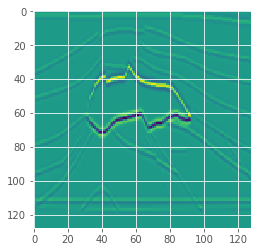

In [16]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
multi_slice_viewer(X.reshape(676,128,128))

In [79]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_3d, y_3d, test_size=0.2, random_state=23)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_2d, y_2d, test_size=0.2, random_state=23)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

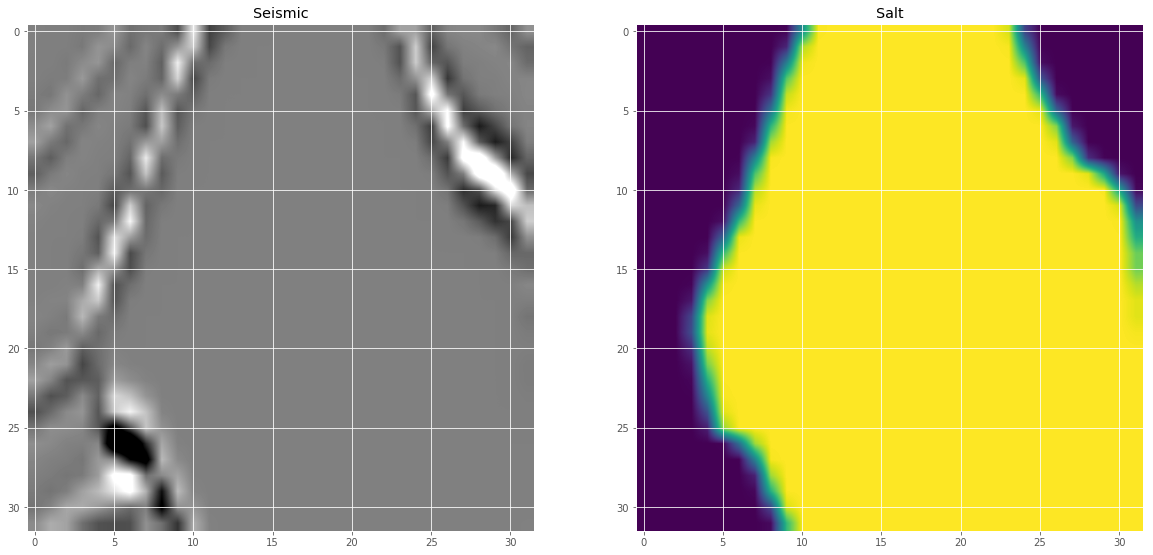

In [62]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix,0].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
vm = np.percentile(X_train[ix,0, ..., 0],99)
ax1.imshow(X_train[ix,0, ..., 0], cmap = 'gray', vmin = -vm, vmax = vm, interpolation = 'bilinear')
# if has_mask: # if salt
#     # draw a boundary(contour) in the original image separating salt and non-salt areas
#     ax1.contour(y_train[ix,15].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix,0].squeeze(), cmap = 'viridis', interpolation = 'bilinear')
ax2.set_title('Salt')

Text(0.5, 1.0, 'Salt')

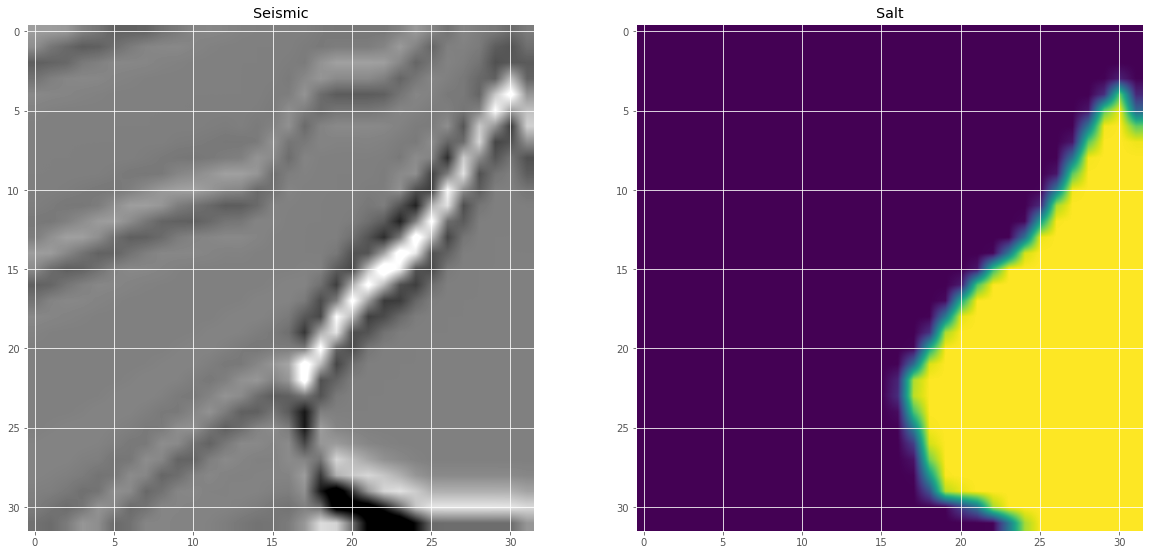

In [101]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
vm = np.percentile(X_train[ix, ..., 0],99)
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', vmin = -vm, vmax = vm, interpolation = 'bilinear')
# if has_mask: # if salt
#     # draw a boundary(contour) in the original image separating salt and non-salt areas
#     ax1.contour(y_train[ix,15].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'viridis', interpolation = 'bilinear')
ax2.set_title('Salt')

In [97]:
def conv3d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv3D(filters = n_filters, kernel_size = (kernel_size, kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv3D(filters = n_filters, kernel_size = (kernel_size, kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [64]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv3d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv3d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling3D((2, 2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv3d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv3d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling3D((2, 2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv3d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv3DTranspose(n_filters * 8, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv3d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv3DTranspose(n_filters * 4, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv3d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv3DTranspose(n_filters * 2, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv3d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv3DTranspose(n_filters * 1, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv3d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [80]:
input_img = Input((im_depth, im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [81]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
conv3d_59 (Conv3D)              (None, 32, 32, 32, 1 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 32, 32, 32, 1 64          conv3d_59[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 32, 32, 32, 1 0           batch_normalization_56[0][0]     
____________________________________________________________________________________________

In [82]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model/3d-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [83]:
results = model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 268 samples, validate on 68 samples
Epoch 1/50
268/268 [==============================] - 130s 486ms/step - loss: 0.5059 - accuracy: 0.8651 - val_loss: 0.4730 - val_accuracy: 0.8929

Epoch 00001: val_loss improved from inf to 0.47296, saving model to 3d-salt.h5
Epoch 2/50
268/268 [==============================] - 137s 512ms/step - loss: 0.3040 - accuracy: 0.9434 - val_loss: 0.2362 - val_accuracy: 0.9715

Epoch 00002: val_loss improved from 0.47296 to 0.23618, saving model to 3d-salt.h5
Epoch 3/50
268/268 [==============================] - 126s 471ms/step - loss: 0.2321 - accuracy: 0.9473 - val_loss: 0.1838 - val_accuracy: 0.9715

Epoch 00003: val_loss improved from 0.23618 to 0.18379, saving model to 3d-salt.h5
Epoch 4/50
268/268 [==============================] - 126s 470ms/step - loss: 0.1788 - accuracy: 0.9524 - val_loss: 0.1739 - val_accuracy: 0.9715

Epoch 00004: val_loss improved from 0.18379 to 0.17386, saving model to 3d-salt.h5
Epoch 5/50
268/268 [===================

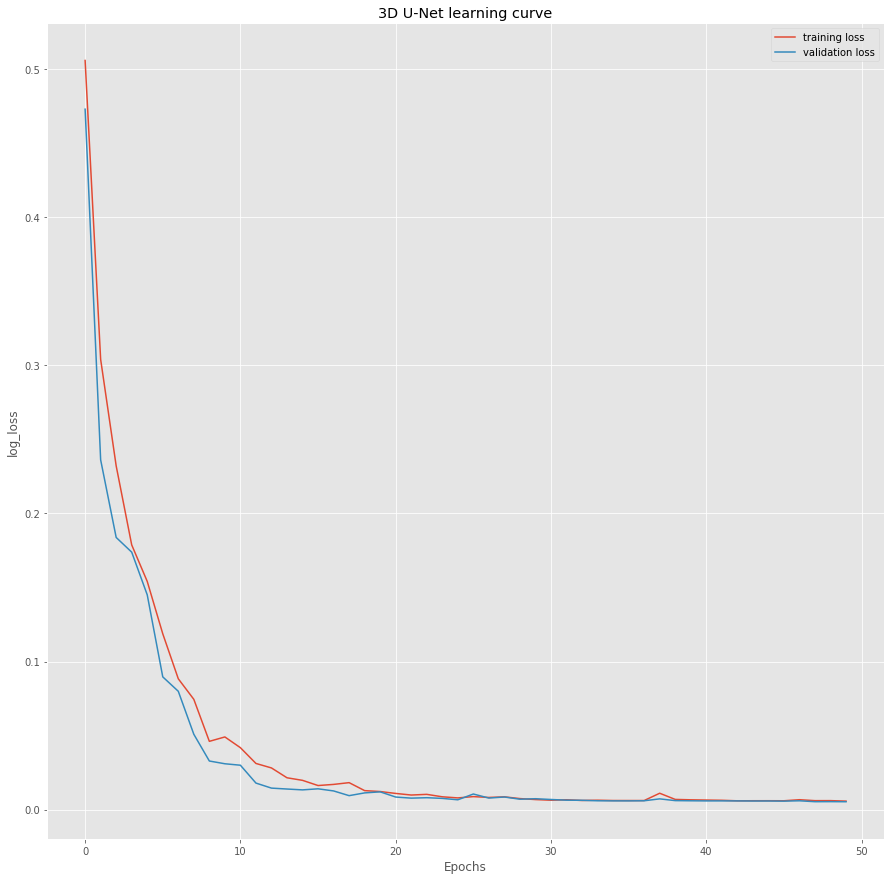

In [89]:
plt.figure(figsize=(15, 15))
plt.title("3D U-Net learning curve")
plt.plot(results.history["loss"], label="training loss")
plt.plot(results.history["val_loss"], label="validation loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [58]:
# load the best model
model.load_weights('3d-salt.h5')

In [59]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

68/68 [==============================] - 2s 29ms/step


[0.030326897607130164, 0.9787884950637817]

In [60]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

68/68 [==============================] - 2s 36ms/step


In [61]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [62]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    #if has_mask:
    #    ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

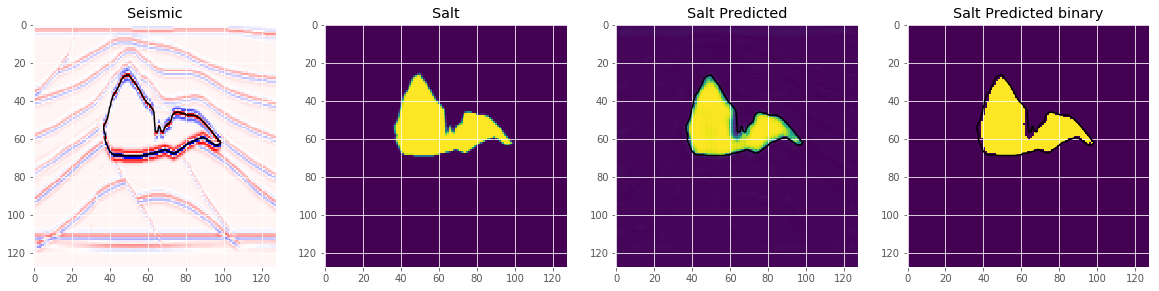

In [63]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

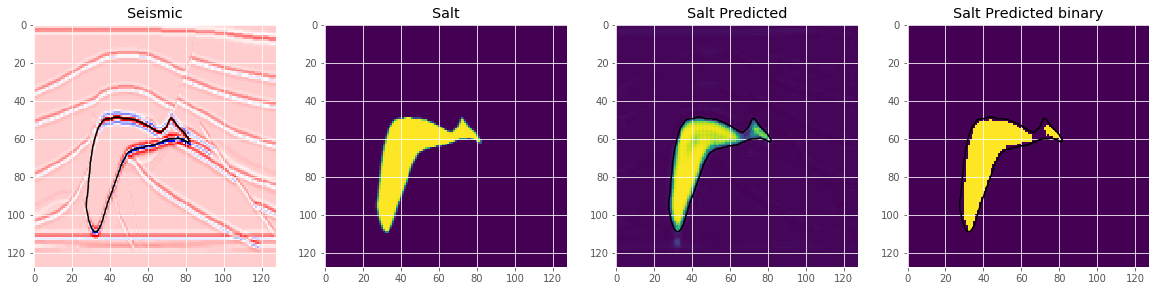

In [65]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

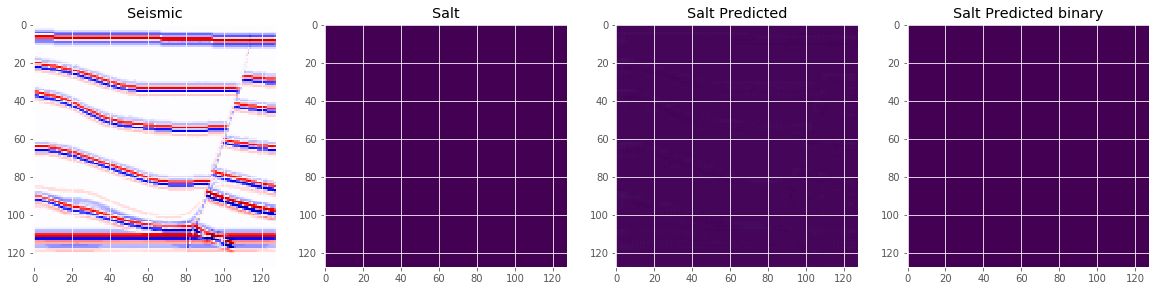

In [66]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

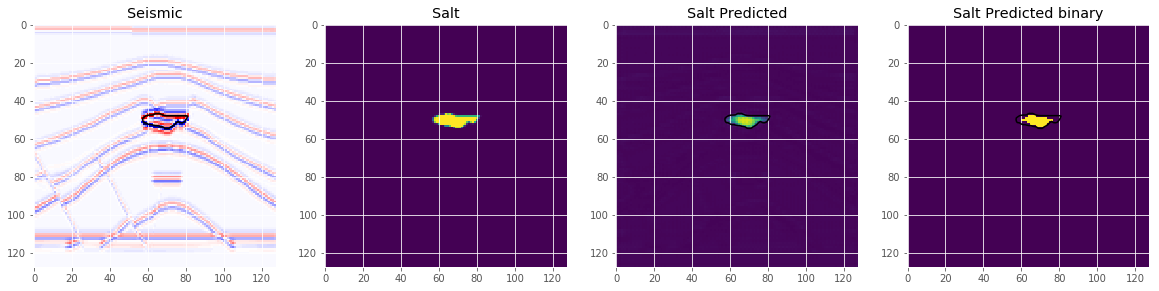

In [67]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

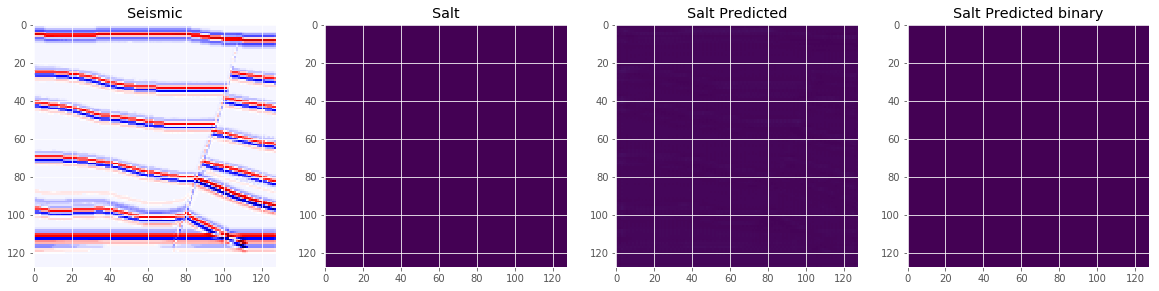

In [68]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

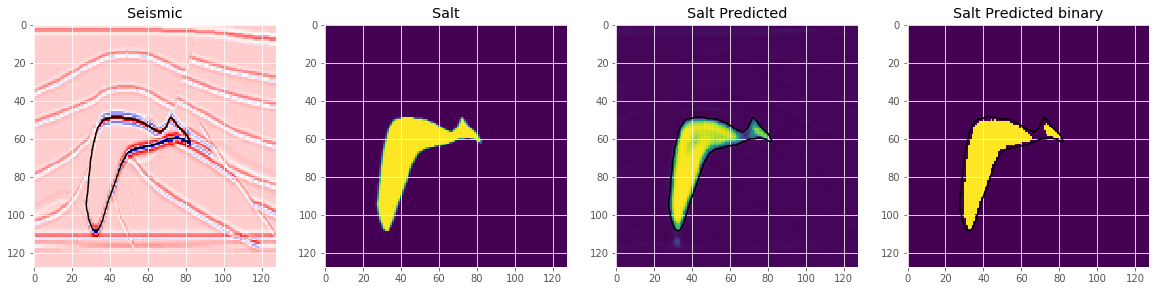

In [69]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

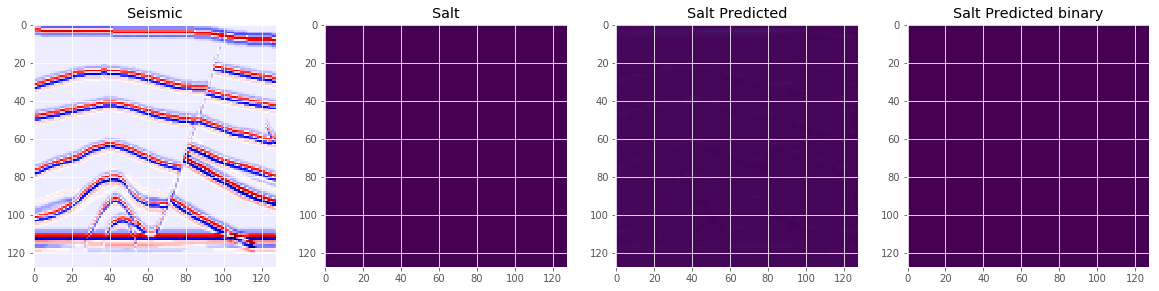

In [70]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

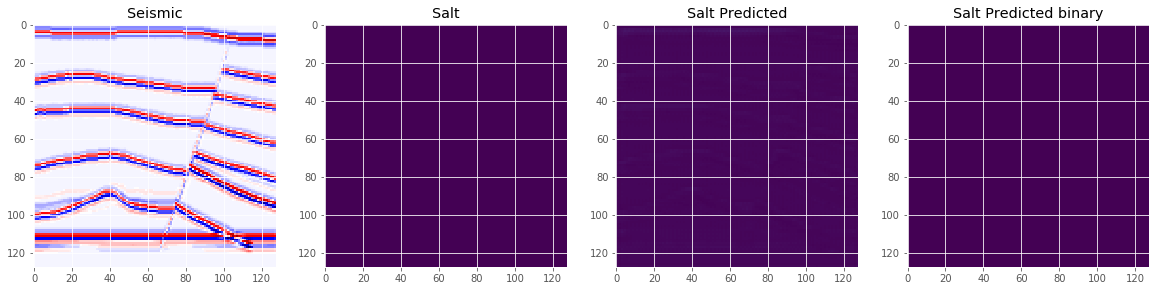

In [71]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

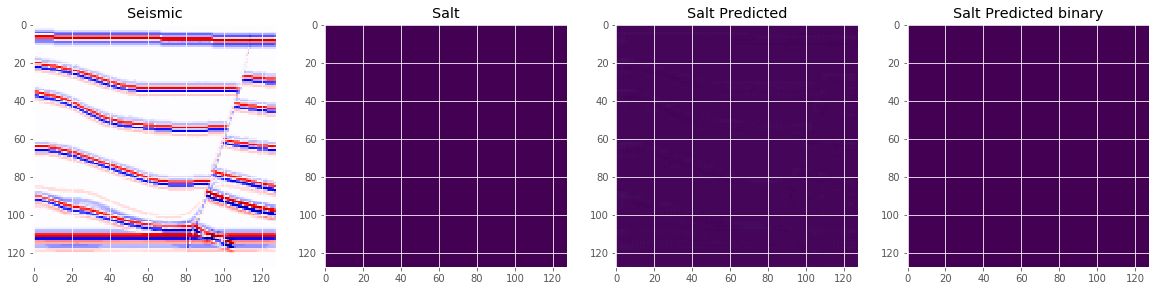

In [72]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

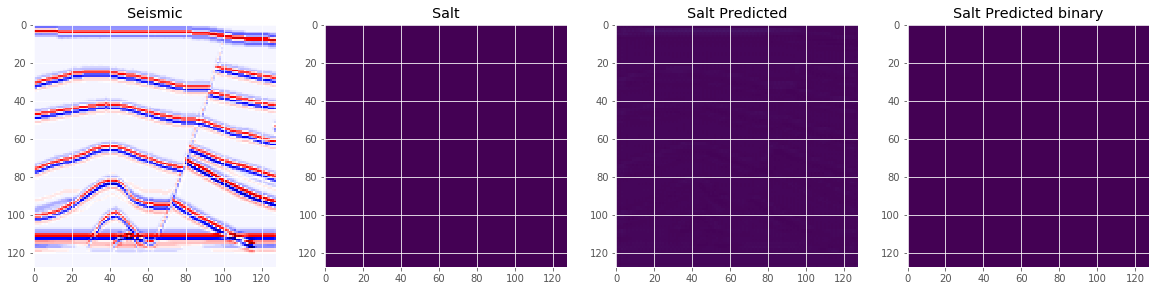

In [73]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

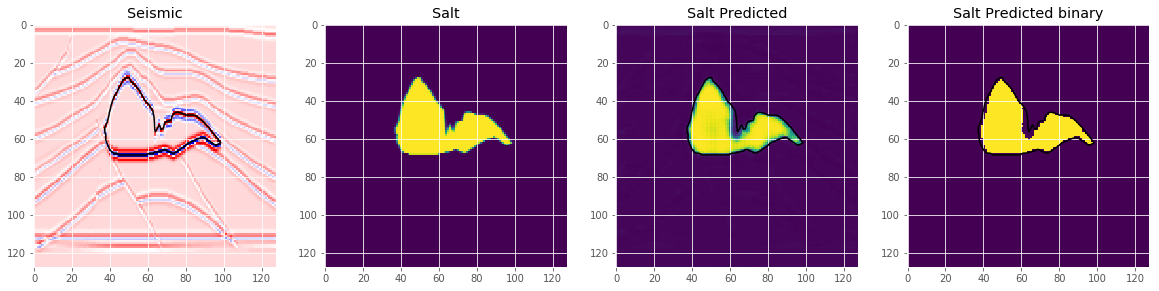

In [74]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

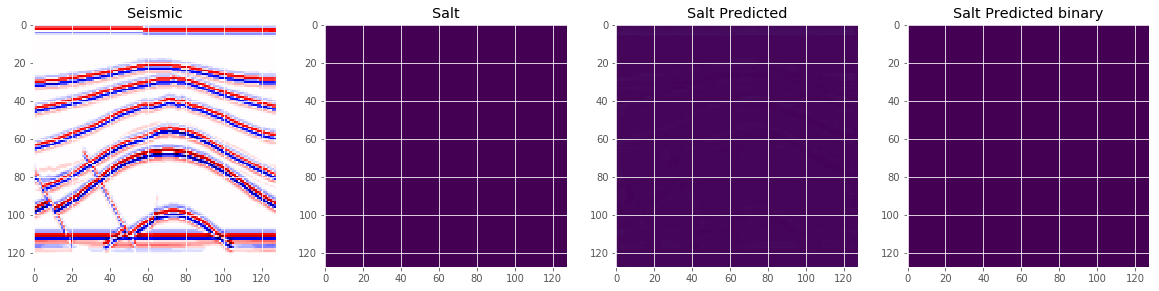

In [75]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

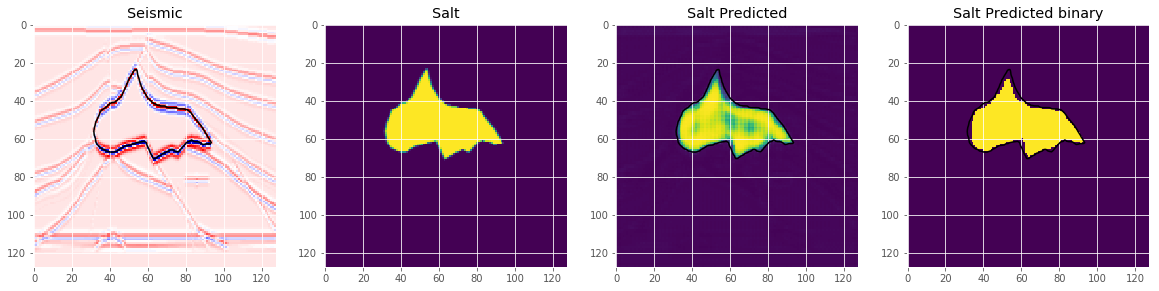

In [76]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

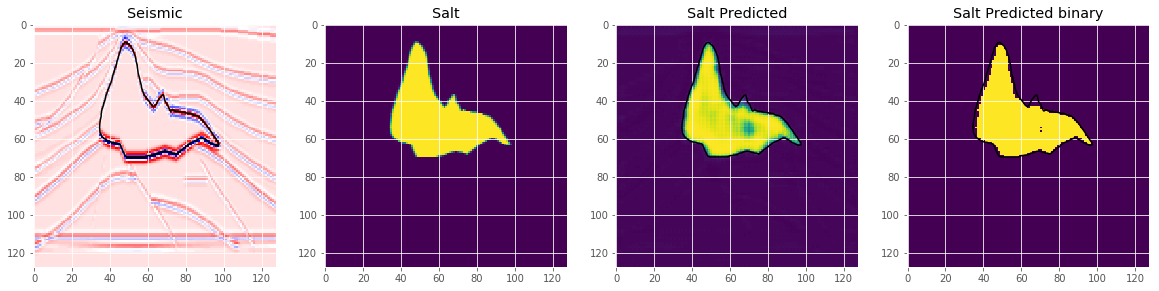

In [77]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

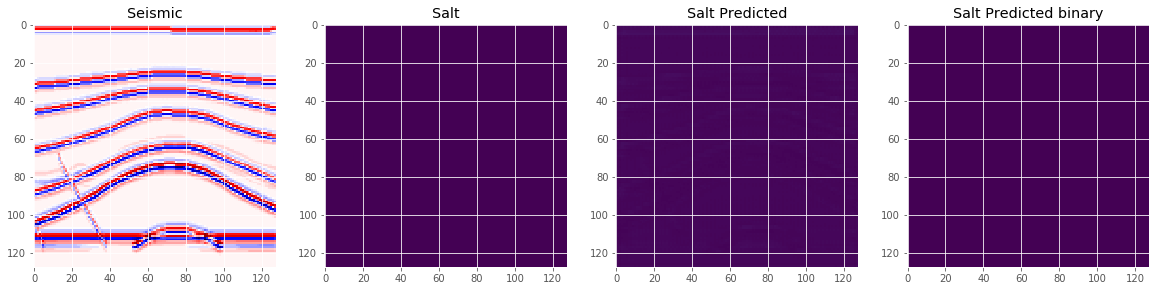

In [78]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

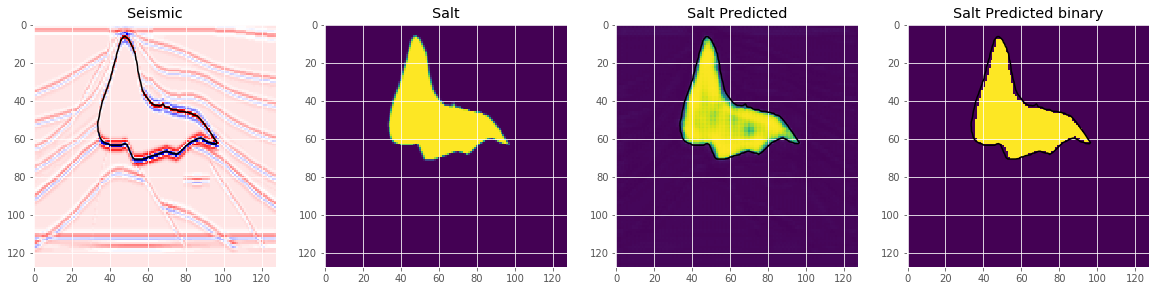

In [79]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

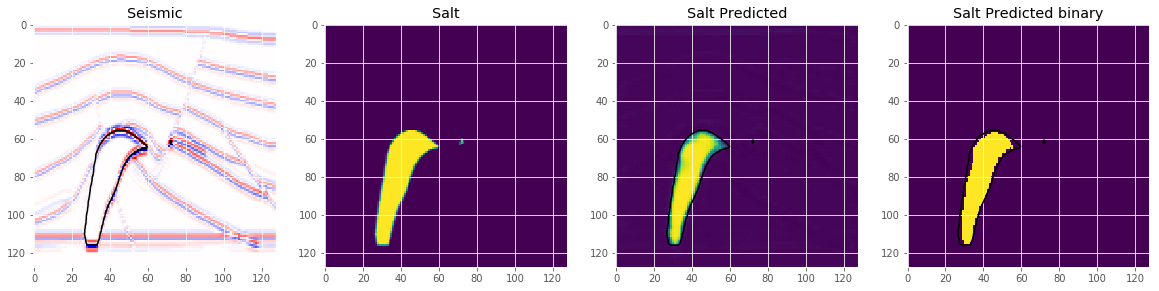

In [80]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

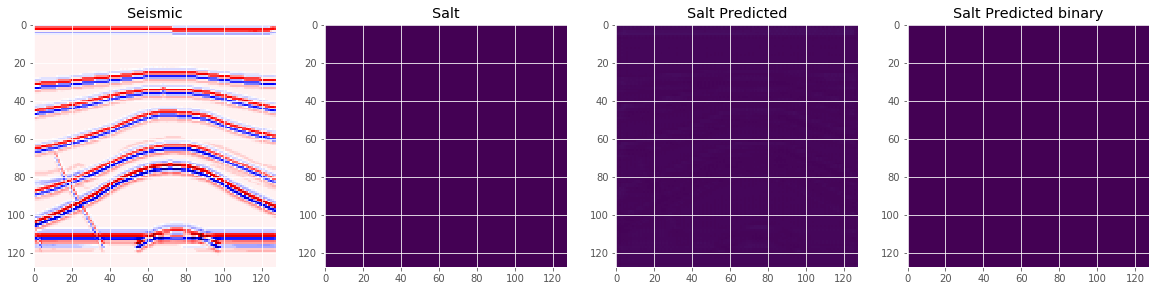

In [81]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

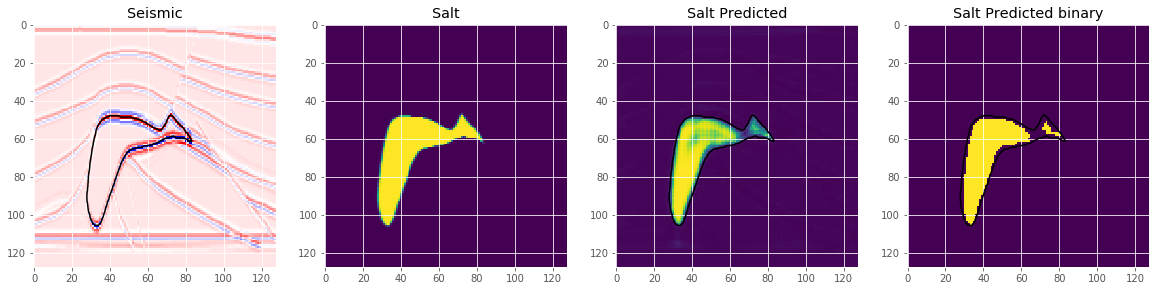

In [82]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

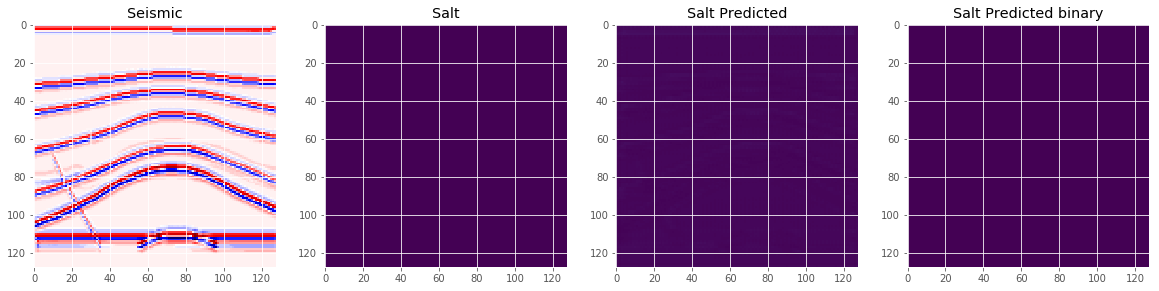

In [83]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

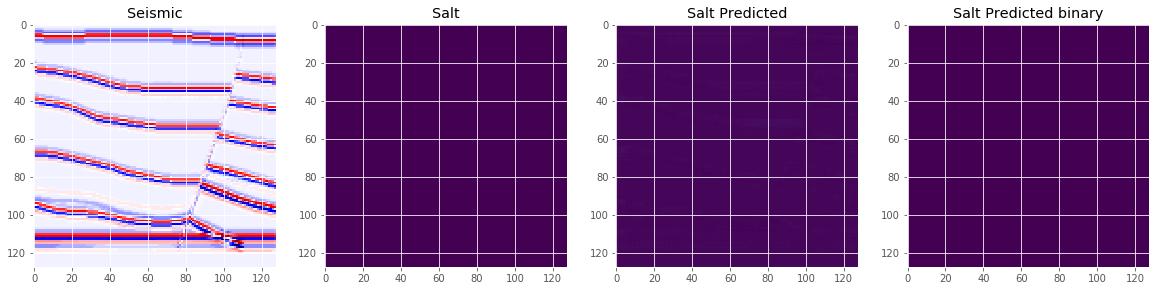

In [84]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

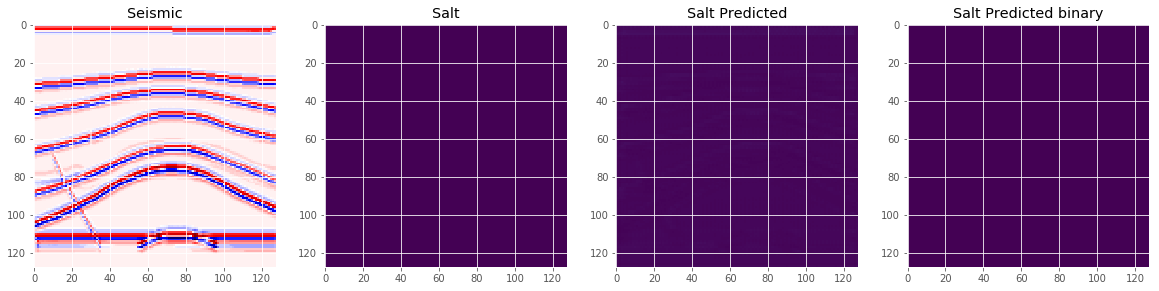

In [85]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

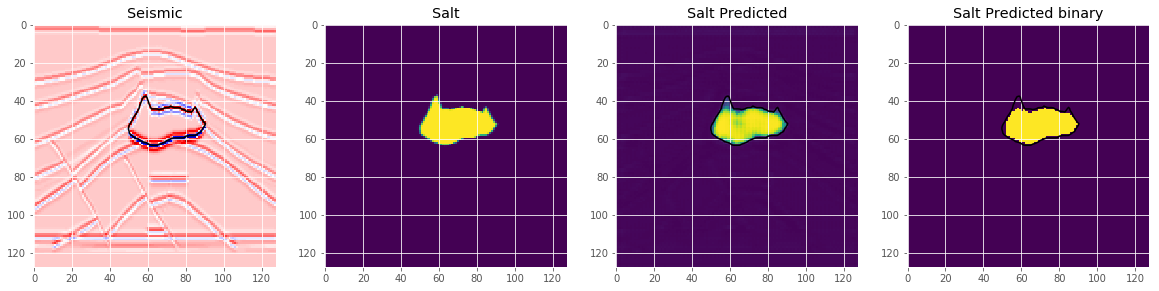

In [86]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

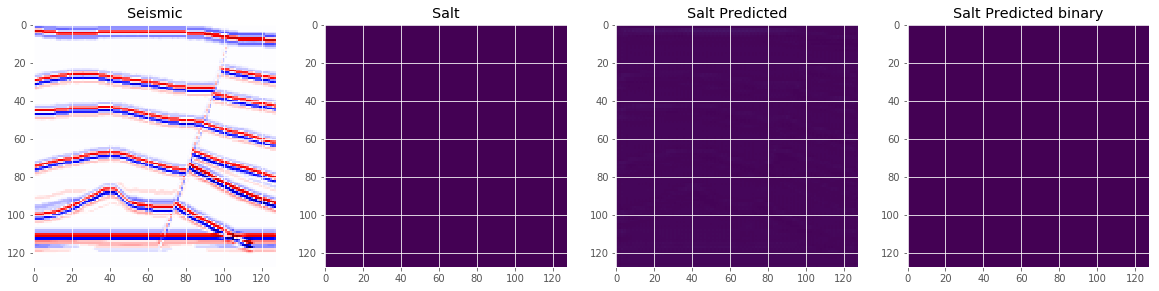

In [87]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

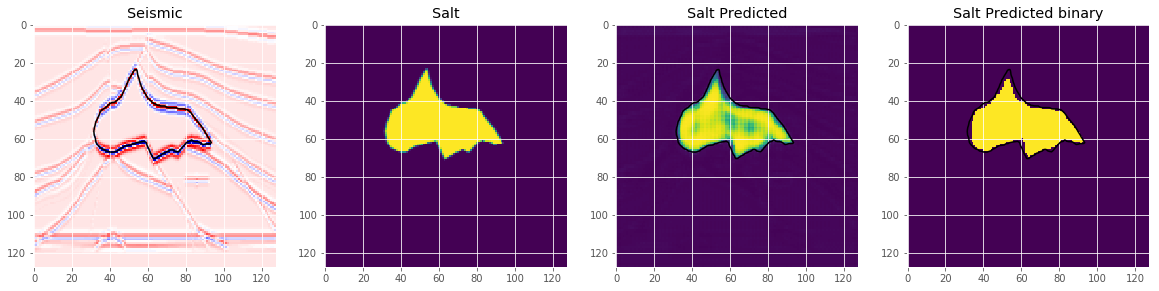

In [88]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

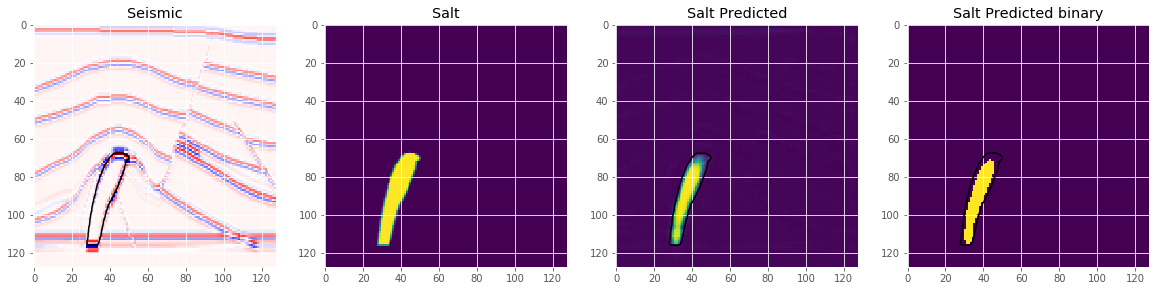

In [89]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

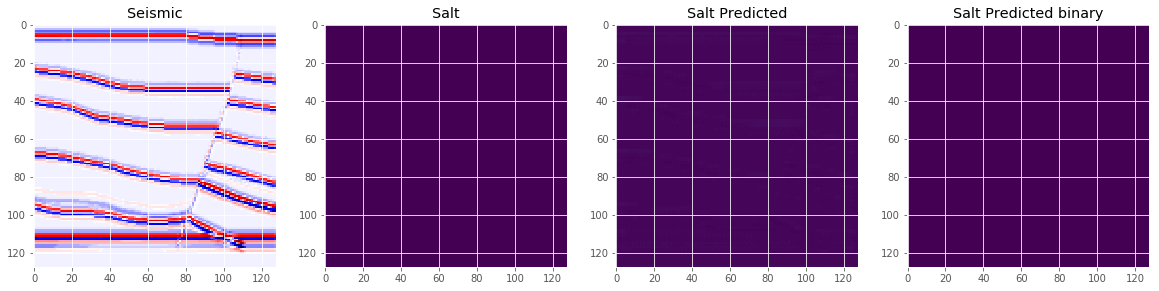

In [90]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

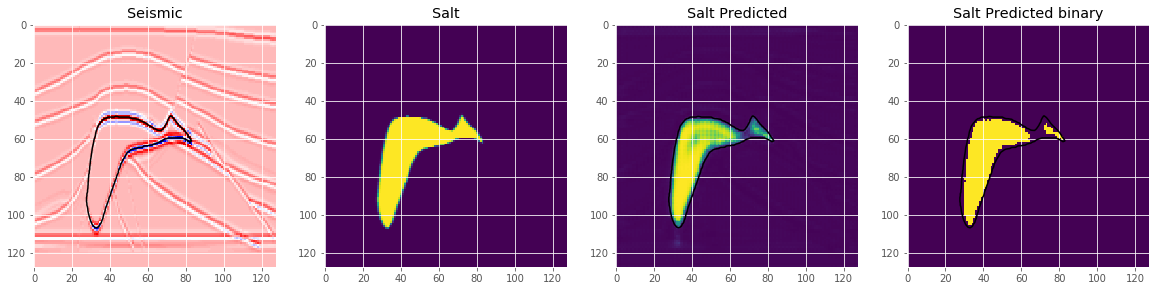

In [91]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [26]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [27]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = False):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [28]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [30]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/2d-salt_32x32.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [31]:
results = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 8601 samples, validate on 2151 samples
Epoch 1/50
8601/8601 [==============================] - 88s 10ms/step - loss: 0.1412 - accuracy: 0.9639 - val_loss: 0.0303 - val_accuracy: 0.9799

Epoch 00001: val_loss improved from inf to 0.03028, saving model to 2d-salt_32x32.h5
Epoch 2/50
8601/8601 [==============================] - 87s 10ms/step - loss: 0.0167 - accuracy: 0.9807 - val_loss: 0.0076 - val_accuracy: 0.9820

Epoch 00002: val_loss improved from 0.03028 to 0.00760, saving model to 2d-salt_32x32.h5
Epoch 3/50
8601/8601 [==============================] - 94s 11ms/step - loss: 0.0083 - accuracy: 0.9808 - val_loss: 0.0061 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.00760 to 0.00605, saving model to 2d-salt_32x32.h5
Epoch 4/50
8601/8601 [==============================] - 145s 17ms/step - loss: 0.0061 - accuracy: 0.9809 - val_loss: 0.0046 - val_accuracy: 0.9821

Epoch 00004: val_loss improved from 0.00605 to 0.00464, saving model to 2d-salt_32x32.h5
Epoch 5/50


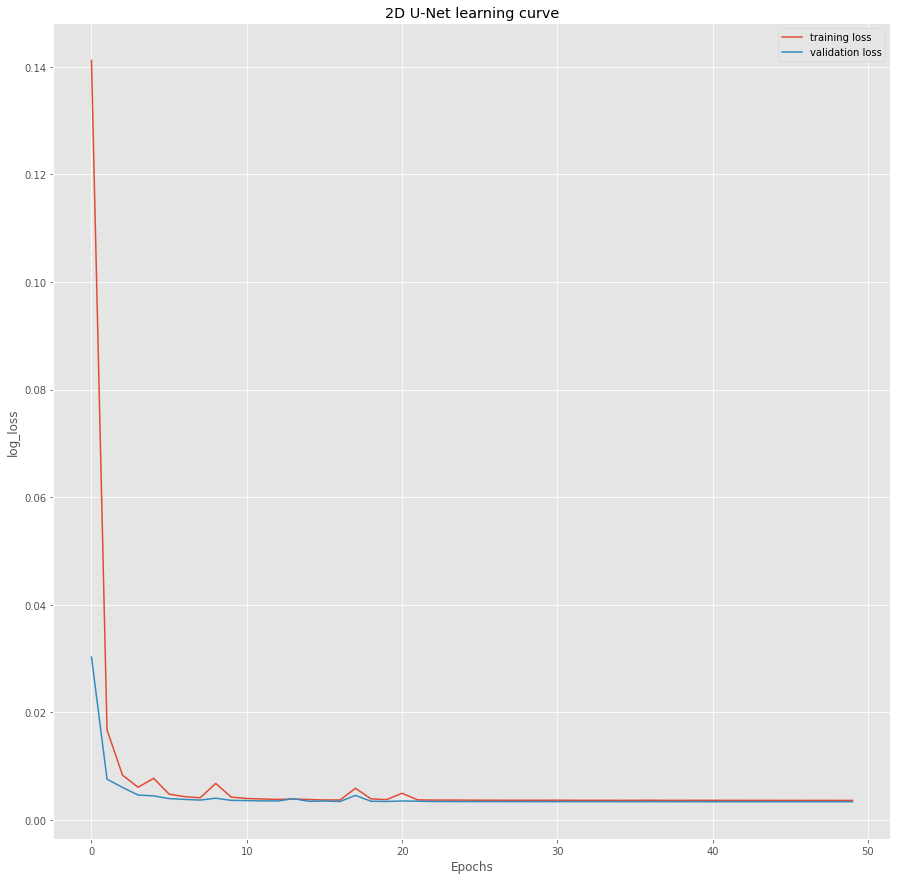

In [34]:
plt.figure(figsize=(15, 15))
plt.title("2D U-Net learning curve")
plt.plot(results.history["loss"], label="training loss")
plt.plot(results.history["val_loss"], label="validation loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();